In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset32-24/(32 24)(Training)Dataset-1.npz
/kaggle/input/dataset32-24/(32 24(Test)Dataset-1.npz


In [2]:
#!/usr/bin/env python
# coding: utf-8

import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, median_absolute_error
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Enable GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-07-07 06:04:06.741046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751868246.936527      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751868246.991233      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Parameters
n_embd = 256   #n_embd should be a multiple of head size     #128,256,512,1024
head_size = 32     # 8,16,32,64,128, 256
filter_size = 15   #0-200
dropout_rate = 0.0  # 0,0.1,0.2,0.3,0.4,0.5
ffdneurons = 512   #256,512,1025,2048,4096
transformer_layers = 1 #1,2,3,4,5,6,7,8,9,10
batch_size = 16    # 6,16,32,64,128,256,512,1024,2048,4096....... < 70,000 # higher the value more gpu consumption, if the consumption is more than gpu space than it can throw error, 
                   # in that case lower the batch_size. 



# donot change the following parameters
block_size = 256-filter_size + 1 #don't change
num_epochs = 1000
inital_learning_rate = 0.01
num_patience = 20
early_stopping_patience = 50 # keep num_patience < early_stopping_patience

In [4]:
input_training_data = "/kaggle/input/dataset32-24/(32 24)(Training)Dataset-1.npz"
input_testing_data = "/kaggle/input/dataset32-24/(32 24(Test)Dataset-1.npz"

Number of Channel available for testing: 10000
                  Number of base-station: 18
      Number of samples/taps per channel: 256
Number of Channel available for training: 70000
                  Number of base-station: 18
      Number of samples/taps per channel: 256


I0000 00:00:1751868285.866832      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1751868295.288693      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


Model: "network_cnn_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (1, 256, 18, 2)             │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (1, 242, 1, 256)            │         138,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (1, 242, 1, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (242, 256)                  │          61,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_block            │ ?                           │         527,104 │
│ (TransformerEncoderBlock)            │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (1, 2)                      │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 729,098 (2.78 MB)

 Trainable params: 728,582 (2.78 MB)

 Non-trainable params: 516 (2.02 KB)

Epoch 1/1000


I0000 00:00:1751868306.236614      58 service.cc:148] XLA service 0x7a9d80016a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751868306.237366      58 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751868310.087321      58 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 103.22247, saving model to models/best_model_full.keras
4375/4375 - 49s - 11ms/step - loss: 99.8481 - mae: 7.6636 - val_loss: 103.2225 - val_mae: 8.0175 - learning_rate: 0.0100
Epoch 2/1000

Epoch 2: val_loss improved from 103.22247 to 53.68026, saving model to models/best_model_full.keras
4375/4375 - 35s - 8ms/step - loss: 47.9156 - mae: 5.3028 - val_loss: 53.6803 - val_mae: 5.7470 - learning_rate: 0.0100
Epoch 3/1000

Epoch 3: val_loss improved from 53.68026 to 13.00443, saving model to models/best_model_full.keras
4375/4375 - 35s - 8ms/step - loss: 23.0595 - mae: 3.6403 - val_loss: 13.0044 - val_mae: 2.8074 - learning_rate: 0.0100
Epoch 4/1000

Epoch 4: val_loss improved from 13.00443 to 3.75852, saving model to models/best_model_full.keras
4375/4375 - 35s - 8ms/step - loss: 10.7622 - mae: 2.4404 - val_loss: 3.7585 - val_mae: 1.4828 - learning_rate: 0.0100
Epoch 5/1000

Epoch 5: val_loss improved from 3.75852 to 2.84235, saving model to models

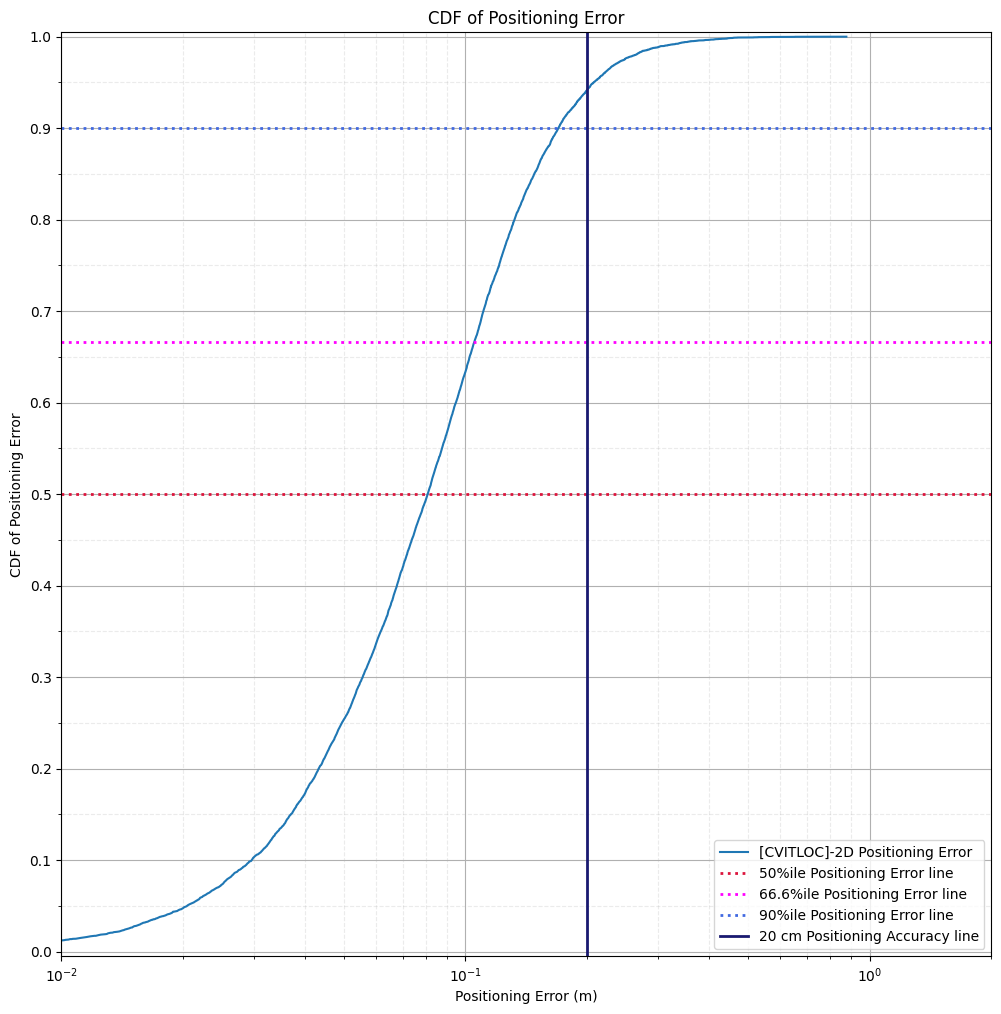

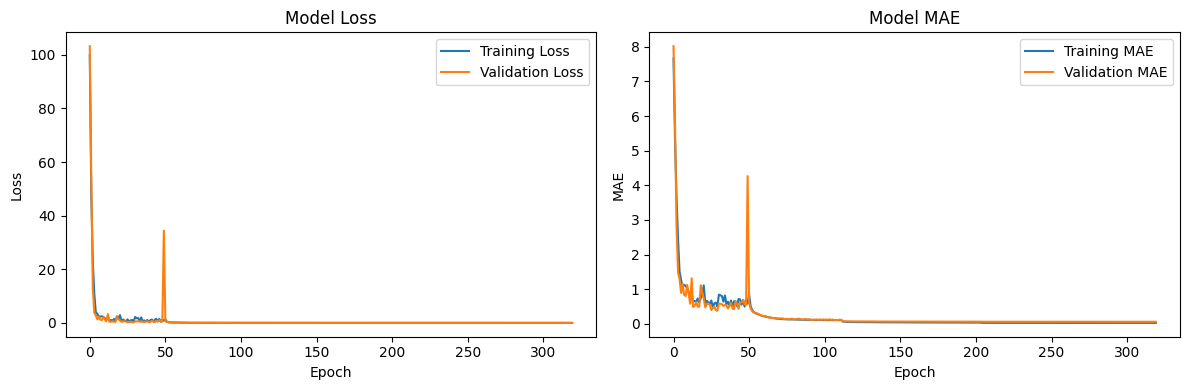


=== MODEL SAVING SUMMARY ===
✓ Full model saved to: models/best_model.keras
✓ Model configuration saved to: models/model_config.json
✓ Training history saved to: models/training_history.npy

=== INSTRUCTIONS FOR LOADING THE MODEL ===
To load the complete model:
  model = tf.keras.models.load_model('models/best_model.keras')

To load just the weights:
  # First recreate the model with same architecture
  model = NetworkCNNTransformer(...)

To load the hyperparameters:
  with open('models/model_config.json', 'r') as f:
      config = json.load(f)


In [5]:
# Load test data
dB = np.load(input_testing_data)

ht_testing = dB["ht.npy"]
ht_testing = np.stack([np.real(ht_testing), np.imag(ht_testing)], axis=-1)
ueLocations_testing = dB["ueLocations"]
bsLocations_testing = dB["bsLocation"]
rsrp_testing = dB["rsrp"]
toaLoS_testing = dB["time_of_arrival_LoS"]

shape = ht_testing.shape
numChannels = shape[0]
numOfBSs = shape[1]
numOfSamples = shape[2]

print("Number of Channel available for testing: " + str(numChannels))
print("                  Number of base-station: " + str(numOfBSs))
print("      Number of samples/taps per channel: " + str(numOfSamples))

# Load training data
dB = np.load(input_training_data)

ht_training = dB["ht.npy"]
ht_training = np.stack([np.real(ht_training), np.imag(ht_training)], axis=-1)
ueLocations_training = dB["ueLocations"]
bsLocations_training = dB["bsLocation"]
rsrp_training = dB["rsrp"]
toaLoS_training = dB["time_of_arrival_LoS"]

shape = ht_training.shape
numChannels = shape[0]
numOfBSs = shape[1]
numOfSamples = shape[2]

print("Number of Channel available for training: " + str(numChannels))
print("                  Number of base-station: " + str(numOfBSs))
print("      Number of samples/taps per channel: " + str(numOfSamples))

@keras.saving.register_keras_serializable()
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
        })
        return config
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, 
                                    (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights
    
    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        
        output = tf.matmul(attention_weights, v)
        
        return output, attention_weights

@keras.saving.register_keras_serializable()
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate, **kwargs):
        super(TransformerEncoderBlock, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.rate = rate
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = self.point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dff': self.dff,
            'rate': self.rate,
        })
        return config
    
    def point_wise_feed_forward_network(self, d_model, dff):
        return tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])
    
    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

@keras.saving.register_keras_serializable()
class NetworkCNNTransformer(tf.keras.Model):
    def __init__(self, n_embd=None, filter_size=None, block_size=None, 
                 ffdneurons=None, dropout_rate=0.1, transformer_layers=1, 
                 head_size=None, **kwargs):
        super(NetworkCNNTransformer, self).__init__(**kwargs)
        
        # Store hyperparameters
        self.n_embd = n_embd
        self.filter_size = filter_size
        self.block_size = block_size
        self.ffdneurons = ffdneurons
        self.dropout_rate = dropout_rate
        self.transformer_layers = transformer_layers
        self.head_size = head_size
        
        # CNN layers
        self.batch_norm_input = tf.keras.layers.BatchNormalization()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=n_embd, 
            kernel_size=(filter_size, 18), 
            strides=1,
            padding='valid'
        )
        self.relu1 = tf.keras.layers.ReLU()
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        
        # Position embedding
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=block_size, 
            output_dim=n_embd
        )
        
        # Custom Transformer encoder blocks
        self.transformer_blocks = []
        for _ in range(transformer_layers):
            self.transformer_blocks.append(
                TransformerEncoderBlock(
                    d_model=n_embd,
                    num_heads=n_embd // head_size,
                    dff=ffdneurons,
                    rate=dropout_rate
                )
            )
        
        # Final layers
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.fc = tf.keras.layers.Dense(2)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'n_embd': self.n_embd,
            'filter_size': self.filter_size,
            'block_size': self.block_size,
            'ffdneurons': self.ffdneurons,
            'dropout_rate': self.dropout_rate,
            'transformer_layers': self.transformer_layers,
            'head_size': self.head_size,
        })
        return config
        
    def call(self, x, training=None):
        # Input normalization
        x = self.batch_norm_input(x, training=training)
        
        # CNN feature extraction
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.batch_norm1(x, training=training)
        
        # Reshape for transformer input: (batch, sequence_length, features)
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, [batch_size, self.block_size, self.n_embd])
        
        # Add positional embeddings
        positions = tf.range(start=0, limit=self.block_size, dtype=tf.int32)
        pos_emb = self.position_embedding(positions)
        x = x + pos_emb
        
        # Apply transformer encoder blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)
        
        # Global average pooling and final prediction
        x = self.global_avg_pool(x)
        x = self.fc(x)
        
        return x

# Data preprocessing functions
def preprocess_data(cir_data, ue_locations):
    """Preprocess CIR data and UE locations"""
    # Reshape CIR data to match expected input format
    cir_reshaped = cir_data.reshape(-1, 2, 256, 18)
    cir_reshaped = np.transpose(cir_reshaped, (0, 2, 3, 1))  # Change to (batch, height, width, channels)
    
    # Extract x, y coordinates
    locations = ue_locations[:, 0:2]
    
    return cir_reshaped.astype(np.float32), locations.astype(np.float32)

# Create datasets
train_cir, train_locations = preprocess_data(ht_training, ueLocations_training)
test_cir, test_locations = preprocess_data(ht_testing, ueLocations_testing)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_cir, train_locations))
train_dataset = train_dataset.batch(batch_size).shuffle(buffer_size=1000)

test_dataset = tf.data.Dataset.from_tensor_slices((test_cir, test_locations))
test_dataset = test_dataset.batch(batch_size)

# Create and compile model with explicit hyperparameters
model = NetworkCNNTransformer(
    n_embd=n_embd,
    filter_size=filter_size,
    block_size=block_size,
    ffdneurons=ffdneurons,
    dropout_rate=dropout_rate,
    transformer_layers=transformer_layers,
    head_size=head_size
)

# Build the model by calling it once
dummy_input = tf.random.normal((1, 256, 18, 2))
_ = model(dummy_input)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=inital_learning_rate),
    loss='mse',
    metrics=['mae']
)

# Print model summary
model.summary()

# Create directories for saving models and results
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Training callbacks with corrected paths
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=num_patience,
    verbose=1,
    min_lr=1e-7
)

# Save both weights and full model

model_checkpoint_full = tf.keras.callbacks.ModelCheckpoint(
    filepath='models/best_model_full.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=early_stopping_patience,
    restore_best_weights=True,
    verbose=1
)

# Custom callback for gradient clipping
class GradientClippingCallback(tf.keras.callbacks.Callback):
    def __init__(self, clip_value=1.0):
        self.clip_value = clip_value
    
    def on_train_batch_end(self, batch, logs=None):
        # Gradient clipping is handled automatically in TensorFlow 2.x optimizers
        pass

# Train the model
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=num_epochs,
    callbacks=[reduce_lr, model_checkpoint_full, 
               early_stopping, GradientClippingCallback()],
    verbose=2
)


# Save model architecture and hyperparameters
model_config = {
    'n_embd': n_embd,
    'filter_size': filter_size,
    'block_size': block_size,
    'ffdneurons': ffdneurons,
    'dropout_rate': dropout_rate,
    'transformer_layers': transformer_layers,
    'head_size': head_size,
    'batch_size': batch_size,
    'inital_learning_rate': inital_learning_rate,
    'num_epochs': num_epochs,
    'num_patience': num_patience,
    'early_stopping_patience': early_stopping_patience
}

import json
with open('models/model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

print("Model configuration saved to models/model_config.json")

# Load best weights for evaluation
try:
    model = tf.keras.models.load_model('/kaggle/working/models/best_model_full.keras')
    print("Loaded best weights successfully")
except:
    print("Could not load best weights, using current weights")

# Make predictions
predictions = model.predict(test_dataset,verbose=2)

# Flatten predictions if needed
if len(predictions.shape) > 2:
    predictions = predictions.reshape(-1, 2)

# Calculate positioning error
error2D = np.linalg.norm(test_locations - predictions, axis=-1)
nUEs = error2D.size

print(f"Mean positioning error: {np.mean(error2D):.4f} m")
print(f"Median positioning error: {np.median(error2D):.4f} m")
print(f"90th percentile error: {np.percentile(error2D, 90):.4f} m")

# Plot CDF
nbins = nUEs
xlimit = error2D.max()
xlimMin = error2D.min()
ylimit = 1

fig, ax = plt.subplots(figsize=(12, 12))

# Calculate CDF
count, bins_count = np.histogram(error2D, bins=nbins, range=[xlimMin, xlimit])
pdf = count / nUEs
cdf = np.cumsum(pdf)
ax.semilogx(bins_count[1:], cdf, label="[CVITLOC]-2D Positioning Error")

# Plot properties
ax.set_xticks([0.01, 0.1, 1, 10], minor=False)
ax.set_yticks(np.linspace(0, ylimit, 11))
ax.set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax.set_xlim([0.01, 2])
ax.set_ylim([-0.005, 1.005])
ax.set_xlabel("Positioning Error (m)")
ax.set_ylabel("CDF of Positioning Error")
ax.set_title("CDF of Positioning Error")

ax.axhline(y=0.5, lw=2, alpha=1, linestyle=':', color="crimson", label="50%ile Positioning Error line")
ax.axhline(y=2/3, lw=2, alpha=1, linestyle=':', color="magenta", label="66.6%ile Positioning Error line")
ax.axhline(y=0.9, lw=2, alpha=1, linestyle=':', color="royalblue", label="90%ile Positioning Error line")
ax.axvline(x=0.2, lw=2, alpha=1, linestyle='-', color="midnightblue", label="20 cm Positioning Accuracy line")

ax.grid(which='minor', alpha=0.25, linestyle='--')
ax.grid(which='major', alpha=1)
ax.legend()
plt.savefig('results/tensorflow_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Save training history
np.save('models/training_history.npy', history.history)

print("\n=== MODEL SAVING SUMMARY ===")
print("✓ Full model saved to: models/best_model.keras")
print("✓ Model configuration saved to: models/model_config.json")
print("✓ Training history saved to: models/training_history.npy")

# Instructions for loading the model
print("\n=== INSTRUCTIONS FOR LOADING THE MODEL ===")
print("To load the complete model:")
print("  model = tf.keras.models.load_model('models/best_model.keras')")
print("\nTo load just the weights:")
print("  # First recreate the model with same architecture")
print("  model = NetworkCNNTransformer(...)")  
print("\nTo load the hyperparameters:")
print("  with open('models/model_config.json', 'r') as f:")
print("      config = json.load(f)")